In [1]:
from bggcomplex import *
import numpy as np

In [5]:
BGG = BGGComplex("A4")
BGG.find_cycles();

In [6]:
Solver = BGGMapSolver(BGG,BGG.zero_root)

In [7]:
Solver.solve(parallel=False);

In [8]:
print(Solver.timer)

{'index': 0.0014438629150390625, 'vect': 0.1313316822052002, 'basis': 0.11853671073913574, 'mult': 0.19329571723937988, 'linalg': 0.5615081787109375}


In [9]:
Solver.check_maps()

checked 1556 cycles, with no problems found!


In [10]:
BGG.compute_signs()

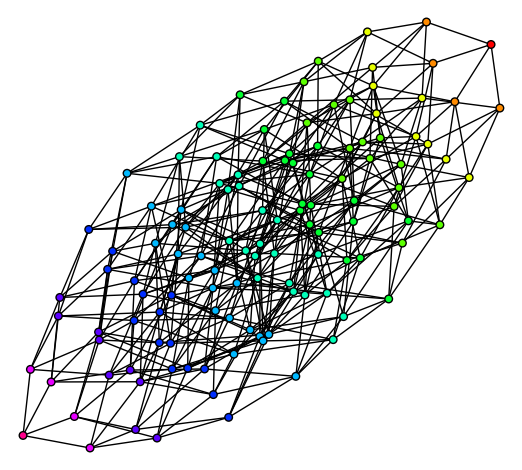

In [11]:
BGG.plot_graph().plot()

In [12]:
roots=BGG.W.domain().simple_roots()
roots

Finite family {1: (1, -1, 0, 0, 0), 2: (0, 1, -1, 0, 0), 3: (0, 0, 1, -1, 0), 4: (0, 0, 0, 1, -1)}

In [13]:
dom = BGG.W.domain()
cr= dom.coroot_lattice()

In [14]:
fun=dom.fundamental_weights_from_simple_roots()
fun

Finite family {1: (4/5, -1/5, -1/5, -1/5, -1/5),  2: (3/5, 3/5, -2/5, -2/5, -2/5),  3: (2/5, 2/5, 2/5, -3/5, -3/5),  4: (1/5, 1/5, 1/5, 1/5, -4/5)}

In [15]:
dom.simple_coroots()

Finite family {1: (1, -1, 0, 0, 0), 2: (0, 1, -1, 0, 0), 3: (0, 0, 1, -1, 0), 4: (0, 0, 0, 1, -1)}

In [16]:
[BGG._weight_to_tuple(r) for r in fun.values()]

[[4/5, 3/5, 2/5, 1/5],
 [3/5, 6/5, 4/5, 2/5],
 [2/5, 4/5, 6/5, 3/5],
 [1/5, 2/5, 3/5, 4/5]]

In [17]:
dom = BGG.W.domain()
dom.simple_coroots()

Finite family {1: (1, -1, 0, 0, 0), 2: (0, 1, -1, 0, 0), 3: (0, 0, 1, -1, 0), 4: (0, 0, 0, 1, -1)}

In [18]:
dom.simple_roots()

Finite family {1: (1, -1, 0, 0, 0), 2: (0, 1, -1, 0, 0), 3: (0, 0, 1, -1, 0), 4: (0, 0, 0, 1, -1)}

In [19]:
BGG._tuple_to_weight([1,1,1/2])

(1, 0, -1/2, -1/2, 0)

In [20]:
mu=fun[1]

In [21]:
mu = BGG.zero_root

In [22]:
[BGG._tuple_to_weight(BGG.dot_action(w,mu))-mu for w in BGG.W]

[(0, 0, 0, 0, 0),
 (0, 0, -1, 1, 0),
 (0, -1, -1, 2, 0),
 (0, 0, -2, 1, 1),
 (-1, -1, -1, 3, 0),
 (0, -1, -2, 2, 1),
 (-1, -1, -2, 3, 1),
 (0, -2, -2, 2, 2),
 (-1, -2, -2, 3, 2),
 (-2, -2, -2, 3, 3),
 (0, -1, 1, 0, 0),
 (0, -2, 1, 1, 0),
 (0, -2, 0, 2, 0),
 (0, -3, 1, 1, 1),
 (-1, -2, 0, 3, 0),
 (0, -3, 0, 2, 1),
 (-1, -3, 0, 3, 1),
 (0, -3, -1, 2, 2),
 (-1, -3, -1, 3, 2),
 (-2, -3, -1, 3, 3),
 (-1, -1, 2, 0, 0),
 (-1, -2, 2, 1, 0),
 (-2, -2, 2, 2, 0),
 (-1, -3, 2, 1, 1),
 (-2, -2, 1, 3, 0),
 (-2, -3, 2, 2, 1),
 (-2, -3, 1, 3, 1),
 (-3, -3, 2, 2, 2),
 (-3, -3, 1, 3, 2),
 (-3, -3, 0, 3, 3),
 (0, 0, 0, -1, 1),
 (0, 0, -1, -1, 2),
 (0, -1, -1, -1, 3),
 (0, 0, -2, 0, 2),
 (-1, -1, -1, -1, 4),
 (0, -1, -2, 0, 3),
 (-1, -1, -2, 0, 4),
 (0, -2, -2, 1, 3),
 (-1, -2, -2, 1, 4),
 (-2, -2, -2, 2, 4),
 (0, -1, 1, -1, 1),
 (0, -2, 1, -1, 2),
 (0, -2, 0, -1, 3),
 (0, -3, 1, 0, 2),
 (-1, -2, 0, -1, 4),
 (0, -3, 0, 0, 3),
 (-1, -3, 0, 0, 4),
 (0, -3, -1, 1, 3),
 (-1, -3, -1, 1, 4),
 (-2, -3, -1, 2, 4)

In [ ]:
def is_dot_regular(mu):
    stab_counter = 0
    for w in BGG.W:
        if w.action(mu+BGG.rho)-BGG.rho==mu:
            stab_counter+=1
    if stab_counter<=1:
        return True
    else:
        return False

In [ ]:
(BGG.rho-fun[1]).is_dominant()

In [25]:
mu=(5*BGG.simple_roots[1]+6*BGG.simple_roots[2]+5*BGG.simple_roots[3])
print(mu.is_dominant())
print(BGG.is_dot_regular(mu))

False
True


In [26]:
BGG.make_dominant(mu)

(
                   [0 1 0 0 0]
                   [1 0 0 0 0]
                   [0 0 1 0 0]
                   [0 0 0 1 0]
(4, 1, 1, -1, -5), [0 0 0 0 1]
)

In [29]:
BGG.LA.adjoint_matrix()

AttributeError: 'LieAlgebraChevalleyBasis_with_category' object has no attribute 'adjoint_matrix'

In [76]:
e = list(BGG.LA.basis())[0]
f = list(BGG.LA.basis())[1]
e

E[alpha[4]]

In [79]:
e+f

E[alpha[4]] + E[alpha[3]]

In [69]:
elt = Solver.maps[('1234232','12342312')]
elt

PBW[-alpha[3]]^2*PBW[-alpha[2]]^2 + 6*PBW[-alpha[3]]*PBW[-alpha[2]]*PBW[-alpha[2] - alpha[3]] + 6*PBW[-alpha[2] - alpha[3]]^2

In [90]:
t=list(list(elt)[0][0])[0][0]

In [108]:
BGG.PBW_alg_gens
BGG.LA.basis()
pbw_to_la={str(value):BGG.LA.basis()[key] for key,value in dict(BGG.PBW_alg_gens).items()}
pbw_to_la

{'PBW[-alpha[1] - alpha[2] - alpha[3] - alpha[4]]': E[-alpha[1] - alpha[2] - alpha[3] - alpha[4]],
 'PBW[-alpha[1] - alpha[2] - alpha[3]]': E[-alpha[1] - alpha[2] - alpha[3]],
 'PBW[-alpha[1] - alpha[2]]': E[-alpha[1] - alpha[2]],
 'PBW[-alpha[1]]': E[-alpha[1]],
 'PBW[-alpha[2] - alpha[3] - alpha[4]]': E[-alpha[2] - alpha[3] - alpha[4]],
 'PBW[-alpha[2] - alpha[3]]': E[-alpha[2] - alpha[3]],
 'PBW[-alpha[2]]': E[-alpha[2]],
 'PBW[-alpha[3] - alpha[4]]': E[-alpha[3] - alpha[4]],
 'PBW[-alpha[3]]': E[-alpha[3]],
 'PBW[-alpha[4]]': E[-alpha[4]],
 'PBW[alpha[1] + alpha[2] + alpha[3] + alpha[4]]': E[alpha[1] + alpha[2] + alpha[3] + alpha[4]],
 'PBW[alpha[1] + alpha[2] + alpha[3]]': E[alpha[1] + alpha[2] + alpha[3]],
 'PBW[alpha[1] + alpha[2]]': E[alpha[1] + alpha[2]],
 'PBW[alpha[1]]': E[alpha[1]],
 'PBW[alpha[2] + alpha[3] + alpha[4]]': E[alpha[2] + alpha[3] + alpha[4]],
 'PBW[alpha[2] + alpha[3]]': E[alpha[2] + alpha[3]],
 'PBW[alpha[2]]': E[alpha[2]],
 'PBW[alpha[3] + alpha[4]]': E[alph

In [115]:
for e in BGG.LA.basis():
    result=0
    for term,coefficient in elt:
        sub_result=e
        for factor,power in term:
            for _ in range(power):
                sub_result=BGG.LA.bracket(pbw_to_la[str(factor)],sub_result)
        result+=sub_result
    print(e,result)

(E[alpha[4]], 0)
(E[alpha[3]], 0)
(E[alpha[2]], 0)
(E[alpha[1]], 0)
(E[alpha[3] + alpha[4]], 0)
(E[alpha[2] + alpha[3]], -3*E[-alpha[2] - alpha[3]])
(E[alpha[1] + alpha[2]], 0)
(E[alpha[2] + alpha[3] + alpha[4]], 0)
(E[alpha[1] + alpha[2] + alpha[3]], 0)
(E[alpha[1] + alpha[2] + alpha[3] + alpha[4]], 0)
(h1, 0)
(h2, 0)
(h3, 0)
(h4, 0)
(E[-alpha[4]], 0)
(E[-alpha[3]], 0)
(E[-alpha[2]], 0)
(E[-alpha[1]], 0)
(E[-alpha[3] - alpha[4]], 0)
(E[-alpha[2] - alpha[3]], 0)
(E[-alpha[1] - alpha[2]], 0)
(E[-alpha[2] - alpha[3] - alpha[4]], 0)
(E[-alpha[1] - alpha[2] - alpha[3]], 0)
(E[-alpha[1] - alpha[2] - alpha[3] - alpha[4]], 0)


We want to implement the $U(\mathfrak g)$ action on the module
$$
    M_i^j=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j+\frac k2}\mathfrak n \right) \right)
$$
For this we need two things, one is finding a basis of this module, and second we define the action on it. Unfortunately I can't find a good out of the box implementation for either of these, so we are going to have to do it ourselves. Ideally we can use this to extend sage a little bit. 

Sagemath has a class FreeModuleTensor, it can deal with alternating and symmetric tensors. But it specifically says it can not deal with tensor products of different modules, whereas that is precisely what we need. We should investigate how this class work, and extend it with this functionality. Besides, that module seems to focus on doing stuff without a specific basis. We want to do everything in a basis, because the whole point is to compute a basis. 

We should make an instance of CombinatorialFreeModule